<a href="https://www.kaggle.com/code/sibindratimalsina/nepali-sentiment-analysis-model-training?scriptVersionId=135443339" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from transformers import TFAutoModel , AutoTokenizer

import matplotlib.pyplot as plt
import os 
import pandas as pd
import torch

from sklearn.preprocessing import LabelEncoder
import numpy as np
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, RandomSampler

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
# Print the list of files in the input directory
print(os.listdir('/kaggle/input/'))

# Load the train and test datasets
df_train = pd.read_csv('/kaggle/input/sentiment-analysis/train.csv')
df_test = pd.read_csv('/kaggle/input/sentiment-analysis/test.csv')

['sentiment-analysis']


#### POSITIVE vs NEGATIVE vs NEUTRAL 

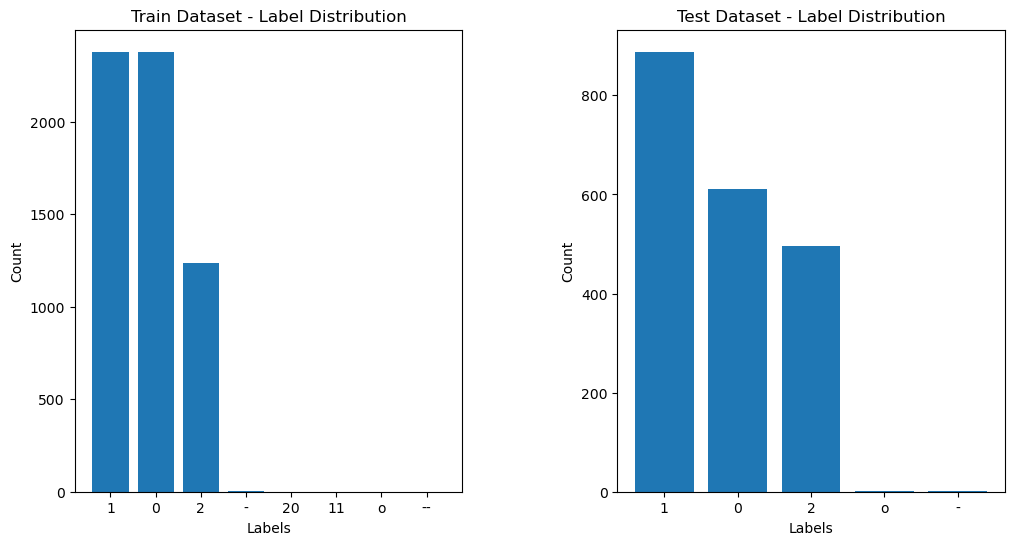

In [3]:
# Bar graph for train dataset
train_labels = df_train['label'].value_counts()

# Bar graph for test dataset
test_labels = df_test['label'].value_counts()

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Train dataset subplot
axs[0].bar(train_labels.index, train_labels.values)
axs[0].set_xlabel('Labels')
axs[0].set_ylabel('Count')
axs[0].set_title('Train Dataset - Label Distribution')

# Test dataset subplot
axs[1].bar(test_labels.index, test_labels.values)
axs[1].set_xlabel('Labels')
axs[1].set_ylabel('Count')
axs[1].set_title('Test Dataset - Label Distribution')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Display the plot
plt.show()


In [4]:
# Checking for missing values in the train dataset
train_na = df_train.isna().sum()
print('Train Dataset - Missing Values:')
print(train_na)

test_na = df_test.isna().sum()
print('\nTest Dataset - Missing Values:')
print(test_na)

Train Dataset - Missing Values:
text     1
label    0
dtype: int64

Test Dataset - Missing Values:
text     1
label    0
dtype: int64


In [5]:
df_train = df_train.dropna()
df_test = df_test.dropna()

# reset indexing 
df_train = df_train.reset_index(drop=True)

In [6]:
# Check for missing values in the train dataset
train_na = df_train.isna().sum()
print('Train Dataset - Missing Values:')
print(train_na)

test_na = df_test.isna().sum()
print('\nTest Dataset - Missing Values:')
print(test_na)

print("Train Dataset Size:",df_train.shape )
print("Test Dataset Size:", df_test.shape)

Train Dataset - Missing Values:
text     0
label    0
dtype: int64

Test Dataset - Missing Values:
text     0
label    0
dtype: int64
Train Dataset Size: (5999, 2)
Test Dataset Size: (1995, 2)


In [7]:
# remove unwanted datas
print(df_train['label'].unique())
print(df_test['label'].unique())

valid_labels = ['0', '1', '2']


# Filter train dataset
df_train = df_train.loc[df_train['label'].isin(valid_labels)]
df_train.loc[:, 'label'] = df_train['label'].astype(int)

# Filter test dataset
df_test = df_test.loc[df_test['label'].isin(valid_labels)]
df_test.loc[:, 'label'] = df_test['label'].astype(int)


['2' '1' '0' '20' '11' '-' 'o' '--']
['1' '0' '2' 'o' '-']


/tmp/ipykernel_24/1816761743.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train.loc[:, 'label'] = df_train['label'].astype(int)
/tmp/ipykernel_24/1816761743.py:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_test.loc[:, 'label'] = df_test['label'].astype(int)


In [8]:
print(df_train['label'])
print(df_test['label'])

0       2
1       1
2       2
3       2
4       1
       ..
5994    1
5995    2
5996    2
5997    1
5998    1
Name: label, Length: 5990, dtype: int64
0       1
1       1
2       1
3       1
4       1
       ..
1991    0
1992    0
1993    0
1994    0
1995    0
Name: label, Length: 1993, dtype: int64


In [9]:
label_encoder = LabelEncoder()

In [10]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

In [11]:
df_train['text'] = df_train['text'].tolist()

print(type(df_train['text']))
print(df_train['text'].head())

<class 'pandas.core.series.Series'>
0    बजार ले जसरी ट्रेन्ड चेन्ज गर्यो यो हेर्दा तत्...
1    1000 अंकले घटेको नेप्से 200 अंकले बढ्नु ठूलो क...
2    होइन यो सानिमा बैंक ले bonus घोसणा गरेको २ महि...
3    खैँ MBJC प्रति कित्तामा रू,10/-ले बढेर आज रू,1...
4                                         राम्रो भयो️️
Name: text, dtype: object


In [12]:
# tokenizing training data
train_tokens = tokenizer.batch_encode_plus(
    df_train['text'].tolist(),
    padding = True,
    truncation = True,
    max_length = 512,
    return_tensors = 'pt'
)

train_labels = label_encoder.fit_transform(df_train['label'])


In [13]:
print(train_labels)

[2 1 2 ... 2 1 1]


In [14]:
# tokenizing test data 
test_tokens = tokenizer.batch_encode_plus(
    df_test['text'].tolist(),
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors='pt'
)

test_labels = label_encoder.fit_transform(df_test['label'])

In [15]:
print(test_labels)

[1 1 1 ... 0 0 0]


In [16]:
# Convert input sequences to tensors
train_input_ids = torch.tensor(train_tokens['input_ids'])
train_attention_masks = torch.tensor(train_tokens['attention_mask'])
train_labels = torch.tensor(df_train['label'].values)

test_input_ids = torch.tensor(test_tokens['input_ids'])
test_attention_masks = torch.tensor(test_tokens['attention_mask'])
test_labels = torch.tensor(df_test['label'].values)

# labels
train_labels = torch.tensor(df_train['label'].values)
test_labels = torch.tensor(df_test['label'].values)


# Create a TensorDataset
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

/tmp/ipykernel_24/3236953423.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_input_ids = torch.tensor(train_tokens['input_ids'])
/tmp/ipykernel_24/3236953423.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_attention_masks = torch.tensor(train_tokens['attention_mask'])
/tmp/ipykernel_24/3236953423.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_input_ids = torch.tensor(test_tokens['input_ids'])
/tmp/ipykernel_24/3236953423.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

In [17]:
type(train_dataset)

torch.utils.data.dataset.TensorDataset

In [18]:
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=3)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual

In [19]:
# Setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [20]:
batch_size = 16
learning_rate = 2e-5
epochs = 10

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
from tqdm import tqdm

# Setting random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Training
model.train()

# Initialize lists to store loss and accuracy values
loss_values = []
accuracy_values = []

for epoch in range(epochs):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}')

    for batch in progress_bar:
        batch = tuple(t.to(device) for t in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()

        # Calculate accuracy
        predicted_labels = torch.argmax(outputs.logits, dim=1)
        correct_predictions += (predicted_labels == batch[2]).sum().item()
        total_predictions += batch[0].size(0)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Apply gradient clipping if necessary
        optimizer.step()

        progress_bar.set_postfix({'Training Loss': loss.item()})

    average_loss = total_loss / len(train_dataloader)
    accuracy = correct_predictions / total_predictions

    # Store loss and accuracy values
    loss_values.append(average_loss)
    accuracy_values.append(accuracy)

    print(f'Epoch {epoch+1}: Average Loss: {average_loss:.4f} - Accuracy: {accuracy:.4f}')


Epoch 1: 100%|██████████| 375/375 [07:58<00:00,  1.28s/it, Training Loss=0.598]


Epoch 1: Average Loss: 0.8969 - Accuracy: 0.5831


Epoch 2: 100%|██████████| 375/375 [07:58<00:00,  1.28s/it, Training Loss=0.933]


Epoch 2: Average Loss: 0.7051 - Accuracy: 0.7030


Epoch 3: 100%|██████████| 375/375 [07:58<00:00,  1.28s/it, Training Loss=0.519]


Epoch 3: Average Loss: 0.5749 - Accuracy: 0.7756


Epoch 4: 100%|██████████| 375/375 [07:58<00:00,  1.28s/it, Training Loss=0.551]


Epoch 4: Average Loss: 0.4731 - Accuracy: 0.8192


Epoch 5: 100%|██████████| 375/375 [07:58<00:00,  1.28s/it, Training Loss=0.46]


Epoch 5: Average Loss: 0.4099 - Accuracy: 0.8417


Epoch 6: 100%|██████████| 375/375 [07:58<00:00,  1.28s/it, Training Loss=0.592]


Epoch 6: Average Loss: 0.3632 - Accuracy: 0.8669


Epoch 7: 100%|██████████| 375/375 [07:58<00:00,  1.28s/it, Training Loss=0.294]


Epoch 7: Average Loss: 0.3246 - Accuracy: 0.8723


Epoch 8: 100%|██████████| 375/375 [07:58<00:00,  1.28s/it, Training Loss=0.754]


Epoch 8: Average Loss: 0.2989 - Accuracy: 0.8781


Epoch 9: 100%|██████████| 375/375 [07:58<00:00,  1.28s/it, Training Loss=0.196]


Epoch 9: Average Loss: 0.2898 - Accuracy: 0.8845


Epoch 10: 100%|██████████| 375/375 [07:58<00:00,  1.28s/it, Training Loss=0.337]

Epoch 10: Average Loss: 0.2681 - Accuracy: 0.8813


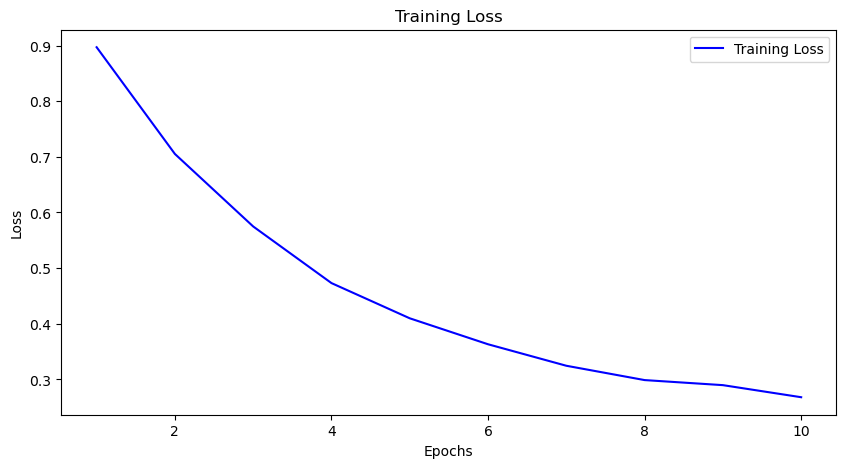

In [22]:
epochs = range(1, epochs+1)

# Loss graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

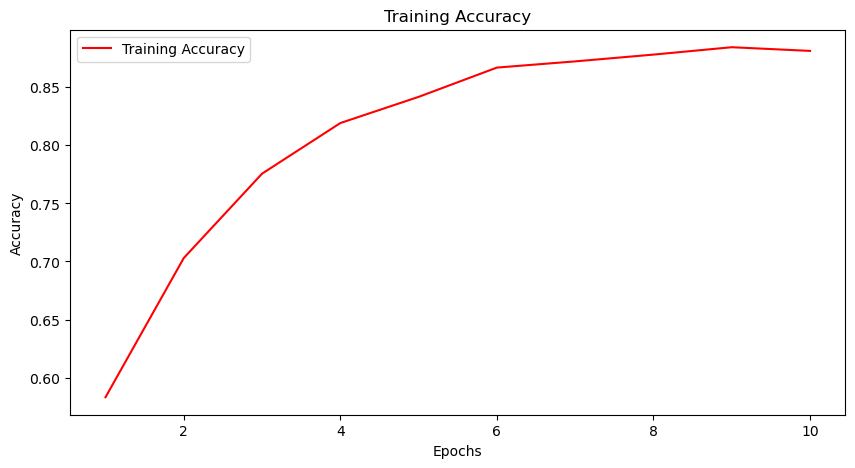

In [23]:
# Accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy_values, 'r', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
# Saving the trained model
output_dir = './trained_model'
os.makedirs(output_dir, exist_ok=True)
model.save_pretrained(output_dir)

print('Training completed!')

Training completed!


In [25]:
# SAVING MODEL
model.save_pretrained("my-model")

# Download
import shutil

model_directory = "my-model"

# Zip the model directory
shutil.make_archive("my-model", 'zip', model_directory)

'/kaggle/working/my-model.zip'